# Universidad Simón Bolívar
## CI-2691 Laboratorio de Algoritmos y Estructuras I
## Estudiante: Astrid Alvarado. Carnet: 18-10938
## Proyecto

# Aprendizaje por Refuerzo

Se conoce como *Aprendizaje por Refuerzo* al aprendizaje en el que un agente, con el tiempo, se instruye para comportarse de manera ópitma en un entorno determinado. Este aprendizaje se consigue mediante la interacción continua con dicho entorno en donde experimenta varias situaciones, denominadas estados, en los cuales puede elegir entre un conjunto de acciones permitidas, obteniendo así recompensas o sanciones. Es así como el agente consigue aprender a maximizar estas recompensas con el fin de comportarse de manera impecable en cualquier estado dado en el que se encuentre.

Uno de las presentaciones más básicas de este aprendizaje es ***Q-Learning***, con el cual se busca mejorar iterativamente el comportamiento del agente con respecto a su aprendizaje mediante el uso de valores Q.

Para su aplicación, se emplea lo siguiente:



*   Valores de acción o valores Q (**Q(S,A)**): son la estimación de tomar cierta acción A en el estado actual S. Estos se calculan de forma iterativa usando la Ecuación de Bellman.
*   Recompensas y episodios: el agente realiza una serie de transiciones en función a su elección de acción y también del entorno en el que interactúa. Durante la transición, el agente toma una acción en el estado actual, observa la recompensa del entorno y luego pasa a otro estado. Si el agente llega a alguno de los estados terminales (zona objetivo o zonas por las cuales no puede pasar), querrá decir que no hay más transición posible, por lo tanto, representa el final de un episodio.
*   Ecuación de Bellman: se representa de la siguiente manera:

    Q(S, A) ← Q(S, A) + α[R + γQ(S', A') - Q(S, A)]
    
    donde:
      *   S: Estado actual del agente.
      *   A: Acción actual seleccionada de acuerdo con la política *ϵ-greedy*.
      * S': Siguiente estado donde va a parar el agente.
      * A': La siguiente mejor acción que se seleccionará utilizando el valor Q máximo en el siguiente estado.
      * R: Recompensa actual observada en el ambiente en respuesta a la acción actual.
      * γ (0< γ <= 1): Factor de descuento para recompensas futuras.
      * α (0< α <= 1): Ratio de aprendizaje que se toma para actualizar la estimación Q(S, A).

*   Elección de la acción a ejecutar con la política de *ϵ-greedy*: el agente interactúa con el ambiente de una de dos formas. La primera, denominada **explotación**, se basa en escoger la siguiente acción tomando como referencia el máximo valor de los valores Q; la segunda, denominada **exploración**, se basa en la selección de una acción a realizar de manera aleatoria. La política de *ϵ-greedy* sirve para balancear esta selección.




# Proyecto: uso de Q-Learning para la exploración de Marte

A manera de ilustrar, se realizará un programa inspirado en la misión Mars 2020, se busca emular el aprendizaje del helicóptero Ingenuity para poder volar y explorar el planeta Marte. El objetivo del robot es conseguir el camino más corto desde donde se encuentre hasta la posición objetivo.

## Implementación

In [1]:
# correr celda para importar las librerías necesarias para
# el correcto funcionamiento de las siguiente funciones a implementar

import sys
import random
import math
import copy
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import colors
from time import sleep

### Entorno

Para crear el entorno donde el agente interactuará, se dibujará un mapa mediante el uso de una lista NxN cuyos elementos se encuentran en el intervalo [0,4]. El terreno estará compuesto por rocas altamente filosas que destruyen por completo al robot si llegase a chocar con estas(rojo oscuro, representado por el número 1), y si el usuario desea más complejidad, añadir cuantas áreas quiera de arenas nocivas que pueden dañar el mecanismo del robot y que este sólo decida cruzar en caso de ser necesario (marrón claro, representado por el número 3). Por lo tanto se tiene que las zonas seguras para explorar Marte serán sobrevolar el terreno por el cielo (morado claro, representado por el número 0) y terreno liso (rojo, representado por el número 2), siendo el cielo la zona más segura para el agente.

Una vez seleccionado el punto objetivo para el robot, será marcado en el mapa (verde, representado por el número 4)

Por lo tanto, el agente deberá ser capaz de aprender a llegar al punto objetivo evadiendo las rocas altamente filosas, recorriendo el cielo, terreno liso y, si el robot lo considera mejor, por la arena nociva.

En términos de Q-Learning, tanto el punto objetivo como las rocas filosas serán zonas terminales.

In [2]:
# Correr la siguiente celda para la visualización del entorno

def environment(planet: [[int]]) -> None:
    '''
    Draw a planet's area for visualization.

    Args:
       planet: a NxN list of integers numbers between 0 and 4
    Returns:
       None
    '''
    N = len(planet)

    data = np.array(planet)

    # create discrete colormap
    cmap = mpl.colors.ListedColormap(['darkred', 'red', 'indianred', 'green'])
    cmap.set_over('plum')
    cmap.set_under('plum')

    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(math.floor(N/3), math.floor(N/3)))

    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height

    width *= fig.dpi
    height *= fig.dpi

    plt.title('Ingenuity Tracker')
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.set_xticks(np.arange(-0, N, 1));
    ax.set_yticks(np.arange(-0, N, 1));
    clear_output(wait=True)

    plt.show()

def robot_tracker(planet: [[int]], pos: (int,int)) -> None:
    '''
    Grafica un área del planeta y grafica el robot, si este se encuentra dentro del área.
    Diferentes valores de planet[i][j] tendrán diferentes colores en el gráfico.
    Función adaptada de:
        https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
    Requiere refactorización.
    Args:
        planet:  lista NxN de números enteros entre 0 y 4.
        pos: tupla (i,j) de números enteros que representa la posición del robot relativa a la matriz planet.

    Retuns:
        None
    '''
    N = len(planet)

    data = np.array(planet)

    # create discrete colormap
    cmap = mpl.colors.ListedColormap(['darkred', 'red', 'indianred', 'green'])
    cmap.set_over('plum')
    cmap.set_under('plum')

    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(math.floor(N/3), math.floor(N/3)))

    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height

    width *= fig.dpi
    height *= fig.dpi

    plt.title('Ingenuity Tracker')
    ax.imshow(data, cmap=cmap, norm=norm)
    if (0 <= pos[0] < len(planet[0])) and (0 <= pos[1] < len(planet)):
        ax.scatter(pos[1], pos[0], marker='s', s= (width/N)**2, color='black')

    # draw gridlines
    ax.set_xticks(np.arange(-0, N, 1));
    ax.set_yticks(np.arange(-0, N, 1));
    clear_output(wait=True)


    plt.show()
    sleep(1)

def robot_show_path(planet: [[int]], positions: [(int, int)]) -> None:
    for i in range(len(positions)):
        robot_tracker(new_map, positions[i])

In [3]:
# Correr la siguiente celda para definir las funciones auxiliares necesarias
# para la creación del mapa.

def sand_function(map: [[int]], n: int) -> None:
    '''
    Changes randomly n elements of the given matrix by number 3.

    Args:
        map: a NxN list of integers numbers between 0 and 2
        n: a positive integer number greater or equal to 0
    Returns:
        None
    '''
    try:
        assert all( all( 0 <= map[i][j] <= 2 for j in range(0,len(map[0])) )  for i in range(0, len(map)) )
        assert n >= 0
    except:
        print('An error has occurred. Check if:\n \t*The elements of the given matrix are between 0 and 2.\n \t*The given number is a positive integer greater or equal to 0.')
        sys.exit()

    for i in range(n):
        d, e = random.choice([k for k in range(len(map)//2, len(map))]), random.choice([k for k in range(len(map))])
        map[d][e] = 3

    try:
        assert all( all( 0 <= map[i][j] <= 3 for j in range(0,len(map[0])) ) for i in range(0, len(map)) )
    except:
        print('An error has occurred.')

def random_environment(map: [[int]], sand: int) -> [[int]]:
    '''
    Given a matrix full of zeros and a positive integer, return a matrix that is half filled with random numbers between 0 and 3

    Args:
      map: a NxN list which elements are zeros
      sand: an integer number greater than or equal to 0

    Returns:
      a matrix that is half filled with random numbers between 0 and 3
    '''
    try:
        assert isinstance(map, list) and isinstance(sand, int)
        assert all(all(map[i][j] == 0 for j in range(0,len(map[0]))) for i in range(0,len(map)))
        assert sand >= 0
    except:
        print('An error has ocurred. Check if:\n \t*The given matrix is full of zeros.\n \t*The given number is greater or equal to zero.\n \t*The inputs are a list and an integer respectively.')
        sys.exit()

    n = len(map)//2
    while n != len(map):
            m = 0
            while m != len(map[0]):
                if  n >= (len(map)//2) + 1:
                    map[n][m] = 2
                    a, b = random.choice([k for k in range(len(map)//2, len(map))]), random.choice([k for k in range(len(map))])
                    map[a][b] = 1
                else:
                    map[n][m] = random.choice([0,1,2])
                m += 1
            n += 1

    for i in range(2, len(map)):
        if map[len(map)//2][i-2] == 0:
            pass
        else:
            if map[len(map)//2][i-1] != 0 and map[len(map)//2][i] != 0:
                map[len(map)//2 - 1][i-1] = 2
            else:
                pass

    if sand == 0:
        pass
    else:
        sand_function(map, sand)

    try:
        assert all( all( 0 <= map[i][j] <= 3 for j in range(0,len(map[0])) ) for i in range(0, len(map)) )
    except:
        print('An error has ocurred.')
        sys.exit()
    return map

def final_point(map: [[int]]) -> (int, int):
    '''
    Ask the user two integers numbers that represent a row and a column of the given matrix,
    these numbers represent the objetive of the robot

    Args:
       map: a NxN list of intengers number between 0 and 4

    Returns:
       a tuple (i, j) which represents a position relative to the matrix.
    '''
    try:
        assert all( all( 0 <= map[i][j] <= 4 for j in range(0,len(map[0])) ) for i in range(0, len(map)) )
    except:
        print('An error has occurred. Check in the elements of the given matrix are between 0 and 4.')
        sys.exit()

    while True:
        try:
            final_X = int(input('Set your coordenate X for the final point: '))
            final_Y = int(input('Set your coordenate Y for the final point: '))
            assert 0 <= final_X < len(map) and 0 <= final_Y < len(map[0])
            break
        except:
            print(f'The given numbers must satisfies 0 <= X <= {len(map)-1} and 0 <= Y <= {len(map[0])-1}')

    return final_X, final_Y

def initial_point(map: [[int]]) -> (int, int):
    '''
    Ask the user two integers numbers that represent a row and a column of the given matrix,
    these numbers represent the initial position of the robot

    Args:
       map: a NxN list of intengers number between 0 and 4

    Returns:
       a tuple (i, j) which represents a position relative to the matrix.
    '''
    try:
        assert all( all( 0 <= map[i][j] <= 4 for j in range(0,len(map[0])) ) for i in range(0, len(map)) )
    except:
        print('An error has occurred. Check in the elements of the given matrix are between 0 and 4.')
        sys.exit()

    while True:
        try:
            initial_X = int(input('Set your coordenate X for the initial point: '))
            initial_Y = int(input('Set your coordenate Y for the inintal point: '))
            assert 0 <= initial_X < len(map) and 0 <= initial_Y < len(map[0])
            break
        except:
            print(f'The given numbers must satisfies 0 <= X <= {len(map)-1} and 0 <= Y <= {len(map[0])-1}')

    return initial_X, initial_Y

def valid_point(map: [[int]], pos: (int, int)) -> bool:
    '''
    Indicates if a position (i,j) is a valid position relative to the matrix, i.e.,
    if it's in the sky or it is on smooth ground

    Args:
       map: a NxN list of integers numbers between 0 and 4
       pos: a tuple (i,j) of positive integers numbers

    Returns:
       True if the elemente in the i row an j column is 0 or 2. Else, returns False.
    '''
    try:
        assert isinstance(map, list) and isinstance(pos, tuple)
        assert all( all( 0 <= map[i][j] <= 4 for j in range(0,len(map[0])) ) for i in range(0, len(map)) )
        assert 0 <= pos[0] < len(map) and 0 <= pos[1] < len(map[0])
    except:
        print(f'An error has ocurred. Check if:\n \t*The matrix´s elements are between 0 and 4.\n \t*The tuple´s elements are between 0 and {len(map)-1}.\n \t*The inputs are a list and a tuple respectively.')
        sys.exit()

    is_valid = True
    if map[pos[0]][pos[1]] == 1 or map[pos[0]][pos[1]] == 3:
        is_valid = not is_valid
    else:
        pass

    try:
        assert is_valid == (map[pos[0]][pos[1]] == 2) or is_valid == (map[pos[0]][pos[1]] == 0)
    except:
        print('An error has ocurred')
    return is_valid


### Estados y recompensas

Al principio, se inicializa una tabla con todos sus valores en 0. Aquí será en donde se almacenen las actualizaciones de nuestros valores Q, esta tabla tendrá como nombre tabla Q.

Por otro lado, se creará una matriz que represente el entorno con las recompensas que recibirá el agente durante la interacción con el mismo. Para este ejemplo, se tiene que las recompensas son:


*   Cielo: -1
*   Terreno liso: -3
*   Arenas nocivas: -5
*   Rocas altamente filosas: -100
*   Punto objetivo: 100

Con estas recompensas se realizará la actualización de los valores Q los cuales servirán como la memoria del agente una vez entrenado en su entorno.



In [4]:
# Valores Q
def q_table(map: [[int]]) -> list:
    '''
    Given a NxN matrix, generates a 3D array with N rows, N columns and 4 depth dimensions
    which elements are zeros.

    Args:
        map: a NxN list
    Returns:
        a 3D array with N rows, N columns and 4 depth dimensions which elements are zeros.
    '''
    try:
        assert len(map)>10 and len(map[0])>10
    except:
        print('An error has occurred. Check if the dimention of the matrix are greater than 10.')
        sys.exit()

    q_values = np.zeros((len(map), len(map[0]), 4))


    return q_values

# Recompensas

def rewards_function(rewards: [[int]], X: int, Y: int) -> None:
    '''
    Given a NxN matrix and two positive integers numbers, changes the values in a range
    of -100 and -5. For the element rewards[X][Y] changes the value by 100

    Args:
       rewards: a NxN list of integer numbers between 0 and 4
       X: a positive integer
       Y: a positive integer

    Returns:
       None
    '''
    # PRECONDICIÓN: ( all( all( 0 <= rewards[i][j] <= 4 for j in range(0, len(rewards[0])) ) for i in range(0,len(rewards)) )
    #                and 0 <= X < len(rewards) and 0 <= Y < len(rewards[0]) )
    # POSTCONDICIÓN: all( all( -100 <= rewards[i][j] <= 100 for j in range(0, len(rewards[0])) ) for i in range(0, len(rewards)) )

    try:
       assert ( all( all( 0 <= rewards[i][j] <= 4 for j in range(0, len(rewards[0])) ) for i in range(0,len(rewards)) )
               and 0 <= X < len(rewards) and 0 <= Y < len(rewards[0]) )
    except:
        print(f'An error has ocurred. Check if:\n \t*The elements of the given matrix are between 0 and 4.\n \t*The given numbers must satisfy 0<=X<={len(rewards)-1} and 0<=Y<={len(rewards[0])-1}')
        sys.exit()

    for k in range(0, len(rewards)):
        for n in range(0, len(rewards[0])):
            if rewards[k][n] == 0:
                rewards[k][n] = -1
            elif rewards[k][n] == 1:
                rewards[k][n] = -100
            elif rewards[k][n] == 2:
                rewards[k][n] = -3
            else:
                rewards[k][n] = -5

    rewards[X][Y] = 100

    try:
        assert all( all( -100 <= rewards[i][j] <= 100 for j in range(0, len(rewards[0])) ) for i in range(0, len(rewards)) )
    except:
        print('An error has ocurred.')
        sys.exit()


### Entrenamiento del modelo

Para el entrenamiento del agente se definirán una serie de funciones que nos servirán para el mismo. Para la función train_AI_agent() se toman los valores:

*     ϵ = 0.1
*     α = 0.9
*     γ = 0.9

Para que el robot pueda entrenar 100000 episodios. Dichos episodios le serán sufientes al robot para que pueda realizar su recorrido al objetivo. Más adelante en la sección de experimentos se explicará la elección de los valores.

In [5]:
# Funciones auxiliares

def terminal_state(rewards: [[int]], new_coord_X: int, new_coord_Y: int) -> bool:
    '''
    Says if a current position is a terminal state, i.e., if a matrix's element in the given
    row and column is -100 or 100.

    Args:
       rewards: a list of list which elements are between -100 and 100
       new_coord_X: an integer that is between 0 and matrix's dimention, last one exclusive
       new_coord_Y: an integer that is between 0 and matrix's dimention, last one exclusive

    Returns:
       True if a matrix's element in the given row and column is -100 or 100. Else, returns False
    '''
    try:
        assert all( all( -100 <= rewards[i][j] <= 100 for j in range(0, len(rewards[0])) ) for i in range(0, len(rewards)) )
        assert 0 <= new_coord_X < len(rewards) and 0 <= new_coord_Y < len(rewards[0])
    except:
        print(f'An error has occurred. Check if:\n \t*The elements of the given matrix are between -100 and 100.\n \t*The given numbers are between 0 and {len(rewards)-1}')
        sys.exit()

    if rewards[new_coord_X][new_coord_Y] == -100 or rewards[new_coord_X][new_coord_Y] == 100:
        is_terminal_state = True
    else:
        is_terminal_state = False

    try:
        assert is_terminal_state == (rewards[new_coord_X][new_coord_Y] == -100) or is_terminal_state == (rewards[new_coord_X][new_coord_Y] == 100)
    except:
        print('An error has occurred')
        sys.exit()

    return is_terminal_state

def start_point(rewards: list) -> (int, int):
    '''
    Returns a random start position for the agent can learn

    Args:
      rewards: a list of list which elements are between -100 and 100

    Returns:
      A tuple with random numbers which represent a start position.
    '''
    try:
        assert all( all( -100 <= rewards[i][j] <= 100 for j in range(0, len(rewards[0])) ) for i in range(0, len(rewards)) )
    except:
        print('An error has occurred. Check if the elements of the given matrix are between -100 and 100.')
        sys.exit()

    new_coord_X, new_coord_Y = random.choice([k for k in range(0,len(rewards))]), random.choice([k for k in range(0,len(rewards[0]))])
    while terminal_state(rewards, new_coord_X, new_coord_Y):
        new_coord_X, new_coord_Y = random.choice([k for k in range(0,len(rewards))]), random.choice([k for k in range(0,len(rewards[0]))])

    try:
        assert 0 <= new_coord_X < len(rewards) and 0 <= new_coord_Y < len(rewards[0])
    except:
        print('An error has occurred.')
        sys.exit()

    return new_coord_X, new_coord_Y

def get_actions(q_values: [[int]], new_coord_X: int, new_coord_Y: int, epsilon: float) -> int:
    '''
    Given an array, two integer numbers and a float, returns a random number between 0 and
    3. This function emulates the ϵ-greedy policy.

    Args:
       q_values: a 3D array with N rows, N columns and 4 depth dimensions
       new_coord_X: a positive integer number
       new_coord_Y: a positive integer number
       epsilon: a float number between 0 and 1

    Returns:
       a number that represent the index in which a actions is choosen.
    '''
    try:
        assert 0 <= epsilon <= 1
        assert 0 <= new_coord_X < len(q_values) and 0 <= new_coord_Y < len(q_values[0])
    except:
        print(f'An error has occurred. Check if:\n \t*The given integer numbers are between 0 and {len(q_values)-1}\n \t*The given float number is between 0 and 1')
        sys.exit()

    if np.random.random() < epsilon:
        index = np.argmax(q_values[new_coord_X, new_coord_Y])
    else:
        index= random.choice([i for i in range(0,4)])

    try:
        assert 0<= index < 4
    except:
        print('An error has occurred.')
        sys.exit()
    return index

def get_locations(new_map: [[int]], new_coord_X: int, new_coord_Y: int, new_action_index: int) -> (int, int):
    '''
    Returns a tuple (i,j) which represents a position according to the action index given and the
    X row and Y column of the matrix

    Args:
        new_map: a NxN list
        new_coord_X: a positive integer number
        new_coord_Y: a positive integer number
        new_action_index: a positive integer number between 0 and 3
    Returns:
        a tuple (i,j) which represents a position on the matrix

    '''
    try:
        assert len(new_map) > 0 and len(new_map[0])>0
        assert 0 <= new_coord_X < len(new_map) and 0 <= new_coord_Y < len(new_map[0])
        assert 0 <= new_action_index <= 3
    except:
        print(f'An error has occurred. Check if:\n \t*The given matrix is not empty.\n \t*The given X and Y numbers are between 0 and {len(new_map)-1}.\n \t*The given index number is between 0 and 3')
        sys.exit()

    X, Y = new_coord_X, new_coord_Y

    actions = ['up', 'left', 'right', 'down']
    if actions[new_action_index] == 'up' and X > 0:
        X -= 1
    elif actions[new_action_index] == 'left' and Y > 0:
        Y -= 1
    elif actions[new_action_index] == 'right' and Y < len(new_map[0])-1:
        Y += 1
    elif actions[new_action_index] == 'down' and X < len(new_map)-1:
        X += 1

    try:
        assert 0 <= X < len(new_map) and 0 <= Y < len(new_map[0])
    except:
        print('An error has occurred.')
        sys.exit()

    return X, Y

def shortest_path(rewards: list, q_values: list, X: int, Y: int) -> [(int, int)]:

    short_path = []
    if terminal_state(rewards, X, Y):
        pass
    else:
        X_1, Y_1 = X, Y
        short_path += [(X, Y)]
        while not terminal_state(rewards, X, Y):
            new_action_index = get_actions(q_values, X, Y, 1)
            X, Y = get_locations(rewards, X, Y, new_action_index)
            short_path += [(X, Y)]

            if len(short_path) > 2:
                if (short_path[len(short_path)-3][0] == short_path[len(short_path)-1][0]) and (short_path[len(short_path)-3][1] == short_path[len(short_path)-1][1]):
                    short_path = [(X_1, Y_1)]
                    break

    return short_path

In [9]:
# Entrenando al Agente de IA usando Q-Learning

def train_AI_agent(rewards: list, q_values: list) -> None:
    epsilon = 0.1    # valor usado para la política ϵ-greedy
    alpha = 0.9      # valor que repesenta el ratio de aprendizaje del agente
    gamma = 0.9      # valor que representa el factor de descuento del agente

    print('Training...')
    for episodes in range(100000):
        if episodes % 10000 == 0:
            print(f'episodes: {episodes}')

        row, column = start_point(rewards)

        while not terminal_state(rewards, row, column):
            action_index = get_actions(q_values, row, column, epsilon)

            old_row, old_column = row, column
            row, column = get_locations(rewards, row, column, action_index)

            reward = rewards[row][column]
            old_q_value = q_values[old_row, old_column, action_index]
            TD = reward + (gamma * np.max(q_values[row, column])) - old_q_value

            new_q_value = old_q_value + (alpha * TD)
            q_values[old_row, old_column, action_index] = new_q_value
    print('Training completed')

### Resultado Final

In [7]:
# Funciones para la interaccion con el usuario

def change_initial_point() -> bool:
    change_i= input('Would you like to change your inital position?\nYes or No: ')
    if change_i == 'Yes' or change_i == 'yes' or change_i == 'YES':
        change_i = True
    else:
        change_i = False
    return change_i

def change_final_point() -> bool:
    change_f = input('Would you like to change your final positions?\nYes or No: ')
    if change_f == 'Yes' or change_f == 'yes' or change_f == 'YES':
        change_f = True
    else:
        change_f = False
    return change_f

def world_creation() -> (list, int, int):
    while True:
        try:
            N = int(input('Set your map size\nEnter a number between 11 and 19: '))
            assert 11 <= N <= 19
            break
        except:
            print('Invalid number.')

    map = []
    for n in range(0, N):
        map += [[0 for k in range(0, N)]]

    sand = input('Do you want your planet to have harmful sand?\nYes or No: ')
    if sand == 'Yes' or sand == 'yes' or sand == 'YES':
        sand = int(input('How many harmful sand do you want on your environment?: '))
    else:
        sand = 0

    new_map = random_environment(map, sand)

    return new_map, N, sand

def wished_world() -> bool:
    while True:
        try:
            is_wished_world = input('This is your generated world. Would you like to change it?\nYes or No: ')
            assert is_wished_world == 'Yes' or is_wished_world == 'yes' or is_wished_world == 'YES' or is_wished_world == 'No' or is_wished_world == 'no' or is_wished_world == 'NO'
            break
        except:
            print('The answer must be a Yes or No answer.\nIt can be used uppercase or lowercase characters.')

    if is_wished_world == 'Yes' or is_wished_world == 'yes' or is_wished_world == 'YES':
        is_wished_world = False
    else:
        is_wished_world = True

    return is_wished_world

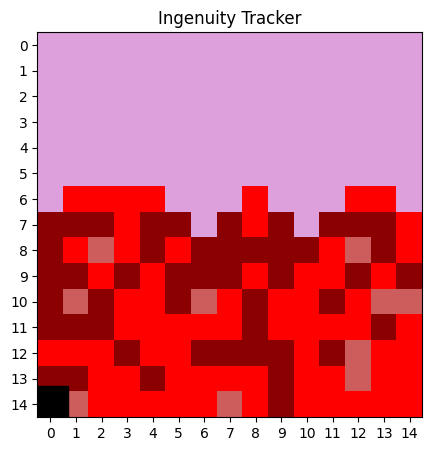

robot´s path: [(10, 7), (11, 7), (11, 6), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (14, 0)]
Would you like to see your robot´s path again?
Yes or No: No
Would you like to change your inital position?
Yes or No: No
Would you like to change your final positions?
Yes or No: No


In [10]:
new_map, N, sand = world_creation()
environment(new_map)
while not wished_world():
    same_values = input('Would you like to use the same old values?\nYes or No: ')
    if same_values == 'Yes' or same_values == 'yes' or same_values == 'YES':
        map = []
        for n in range(0, N):
            map += [[0 for k in range(0, N)]]

        new_map = random_environment(map, sand)
        environment(new_map)
    else:
        new_map, N, sand = world_creation()
        environment(new_map)

objetive = final_point(new_map)
while not valid_point(new_map, objetive):
    print('The objetive can´t be a sharp rock or a harmful sand. Please enter another objetive.')
    objetive = final_point(new_map)

new_map[objetive[0]][objetive[1]] = 4

environment(new_map)

q_values = q_table(new_map)

rewards = copy.deepcopy(new_map)
rewards_function(rewards, objetive[0], objetive[1])

train_AI_agent(rewards, q_values)

initial_position = initial_point(new_map)
while not valid_point(new_map, initial_position):
    print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
    initial_position = initial_point(new_map)

positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

while len(positions) == 1:
    print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

robot_show_path(new_map, positions)
print(f'robot´s path: {positions}')

review = input('Would you like to see your robot´s path again?\nYes or No: ')
while review == 'Yes' or review == 'yes' or review == 'YES':
    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')
    review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_initial_point():
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_final_point():
    new_map[objetive[0]][objetive[1]] = 2

    objetive = final_point(new_map)
    while not valid_point(new_map, objetive):
        print('The objetive can´t be a sharp rock or harmful sand. Please enter another objetive.')
        objetive = final_point(new_map)

    new_map[objetive[0]][objetive[1]] = 4

    environment(new_map)

    q_values = q_table(new_map)

    rewards = copy.deepcopy(new_map)
    rewards_function(rewards, objetive[0], objetive[1])

    train_AI_agent(rewards, q_values)

    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')
        review = input('Would you like to see your robot´s path again?\nYes or No: ')

    while change_initial_point():
        initial_position = initial_point(new_map)
        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
        while len(positions) == 1:
            print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
            initial_position = initial_point(new_map)

            while not valid_point(new_map, initial_position):
                print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
                initial_position = initial_point(new_map)

            positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')
        while review == 'Yes' or review == 'yes' or review == 'YES':
            robot_show_path(new_map, positions)
            print(f'robot´s path: {positions}')
            review = input('Would you like to see your robot´s path again?\nYes or No: ')

#<mark>comentario cchang</mark>

Me parece que 100000 episodios puede ser mucho para un mapa de 11x11. Otros proyectos corren con apenas 10000. El entrenamiento debería ser un parámetro que el usuario pueda controlar.


# Experimentos

Se analizará:
* Valores distintos de epsilon para ver el comportamiento del agente con respecto a la política ϵ-greedy. Entre estos:
  * ϵ = 0.05
  * ϵ = 0.5
  * ϵ = 0.9
* Valores distintos de γ para ver el comportamiento del agente con respecto a la tasa de descuento en su aprendizaje. Entre estos:
  * γ = 0.05
  * γ = 0.5
* Valores distintos de α para ver el comportamiento del agente con respecto al ratio de aprendizaje. Entre estos:
  * α = 0.05
  * α = 0.5

Esto con el fin de ver el comportamiento del agente en su entorno y si es capaz de cumplir con el objetivo.

## Primera prueba:
### Caso con valores bajos

Para este caso donde los valores de ϵ, γ y α son muy bajos el agente es capaz de aprender caminos cortos y sencillos al objetivo, lo que sugiere que es necesario más de 100000 episodios para que logre su objetivo. Sin embargo con mapas más complicados le cuesta más aprender sobre su entorno, pudiendo ser que no llegue a aprender lo suficiente. Además con mapas más grandes de 11 tarda más y mayormente no logra aprender a caminar.

In [ ]:
# Entrenando al Agente de IA usando Q-Learning

def train_AI_agent_1(rewards: list, q_values: list) -> None:
    epsilon = 0.05
    alpha = 0.05
    gamma = 0.05

    print('Training...')
    for episodes in range(100000):
        if episodes % 1000 == 0:
            print(f'episodes: {episodes}')

        row, column = start_point(rewards)

        while not terminal_state(rewards, row, column):
            action_index = get_actions(q_values, row, column, epsilon)

            old_row, old_column = row, column
            row, column = get_locations(rewards, row, column, action_index)

            reward = rewards[row][column]
            old_q_value = q_values[old_row, old_column, action_index]
            TD = reward + (gamma * np.max(q_values[row, column])) - old_q_value

            new_q_value = old_q_value + (alpha * TD)
            q_values[old_row, old_column, action_index] = new_q_value
    print('Training completed')

In [ ]:
new_map, N, sand = world_creation()
environment(new_map)
while not wished_world():
    same_values = input('Would you like to use the same old values?\nYes or No: ')
    if same_values == 'Yes' or same_values == 'yes' or same_values == 'YES':
        map = []
        for n in range(0, N):
            map += [[0 for k in range(0, N)]]

        new_map = random_environment(map, sand)
        environment(new_map)
    else:
        new_map, N, sand = world_creation()
        environment(new_map)

objetive = final_point(new_map)
while not valid_point(new_map, objetive):
    print('The objetive can´t be a sharp rock or a harmful sand. Please enter another objetive.')
    objetive = final_point(new_map)

new_map[objetive[0]][objetive[1]] = 4

environment(new_map)

q_values = q_table(new_map)

rewards = copy.deepcopy(new_map)
rewards_function(rewards, objetive[0], objetive[1])

train_AI_agent_1(rewards, q_values)

initial_position = initial_point(new_map)
while not valid_point(new_map, initial_position):
    print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
    initial_position = initial_point(new_map)

positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

while len(positions) == 1:
    print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

robot_show_path(new_map, positions)
print(f'robot´s path: {positions}')

review = input('Would you like to see your robot´s path again?\nYes or No: ')
while review == 'Yes' or review == 'yes' or review == 'YES':
    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')
    review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_initial_point():
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_final_point():
    new_map[objetive[0]][objetive[1]] = 2

    objetive = final_point(new_map)
    while not valid_point(new_map, objetive):
        print('The objetive can´t be a sharp rock or harmful sand. Please enter another objetive.')
        objetive = final_point(new_map)

    new_map[objetive[0]][objetive[1]] = 4

    environment(new_map)

    q_values = q_table(new_map)

    rewards = copy.deepcopy(new_map)
    rewards_function(rewards, objetive[0], objetive[1])

    train_AI_agent_1(rewards, q_values)

    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')
        review = input('Would you like to see your robot´s path again?\nYes or No: ')

    while change_initial_point():
        initial_position = initial_point(new_map)
        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
        while len(positions) == 1:
            print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
            initial_position = initial_point(new_map)

            while not valid_point(new_map, initial_position):
                print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
                initial_position = initial_point(new_map)

            positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')
        while review == 'Yes' or review == 'yes' or review == 'YES':
            robot_show_path(new_map, positions)
            print(f'robot´s path: {positions}')
            review = input('Would you like to see your robot´s path again?\nYes or No: ')

## Segunda Prueba:
### Caso donde los valores son intermedios

Para este caso donde ϵ, γ y α son valores intermedios se puede notar que el agente, para mapas de tamaño 11x11, tarda menos en aprender a llegar al punto objetivo. Sin embargo, con mapas de mayor tamaño tarda mucho más o no consigue aprender. Adicionalmente, la complejitud de los mapas influyen en su aprendizaje, consiguiendo mejores desempeño en un mapa sin muchos obstáculos.

In [ ]:
# Entrenando al Agente de IA usando Q-Learning

def train_AI_agent_2(rewards: list, q_values: list) -> None:
    epsilon = 0.5
    alpha = 0.5
    gamma = 0.5

    print('Training...')
    for episodes in range(100000):
        if episodes % 1000 == 0:
            print(f'episodes: {episodes}')

        row, column = start_point(rewards)

        while not terminal_state(rewards, row, column):
            action_index = get_actions(q_values, row, column, epsilon)

            old_row, old_column = row, column
            row, column = get_locations(rewards, row, column, action_index)

            reward = rewards[row][column]
            old_q_value = q_values[old_row, old_column, action_index]
            TD = reward + (gamma * np.max(q_values[row, column])) - old_q_value

            new_q_value = old_q_value + (alpha * TD)
            q_values[old_row, old_column, action_index] = new_q_value
    print('Training completed')

In [ ]:
new_map, N, sand = world_creation()
environment(new_map)
while not wished_world():
    same_values = input('Would you like to use the same old values?\nYes or No: ')
    if same_values == 'Yes' or same_values == 'yes' or same_values == 'YES':
        map = []
        for n in range(0, N):
            map += [[0 for k in range(0, N)]]

        new_map = random_environment(map, sand)
        environment(new_map)
    else:
        new_map, N, sand = world_creation()
        environment(new_map)

objetive = final_point(new_map)
while not valid_point(new_map, objetive):
    print('The objetive can´t be a sharp rock or a harmful sand. Please enter another objetive.')
    objetive = final_point(new_map)

new_map[objetive[0]][objetive[1]] = 4

environment(new_map)

q_values = q_table(new_map)

rewards = copy.deepcopy(new_map)
rewards_function(rewards, objetive[0], objetive[1])

train_AI_agent_2(rewards, q_values)

initial_position = initial_point(new_map)
while not valid_point(new_map, initial_position):
    print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
    initial_position = initial_point(new_map)

positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

while len(positions) == 1:
    print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

robot_show_path(new_map, positions)
print(f'robot´s path: {positions}')

review = input('Would you like to see your robot´s path again?\nYes or No: ')
while review == 'Yes' or review == 'yes' or review == 'YES':
    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')
    review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_initial_point():
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_final_point():
    new_map[objetive[0]][objetive[1]] = 2

    objetive = final_point(new_map)
    while not valid_point(new_map, objetive):
        print('The objetive can´t be a sharp rock or harmful sand. Please enter another objetive.')
        objetive = final_point(new_map)

    new_map[objetive[0]][objetive[1]] = 4

    environment(new_map)

    q_values = q_table(new_map)

    rewards = copy.deepcopy(new_map)
    rewards_function(rewards, objetive[0], objetive[1])

    train_AI_agent_2(rewards, q_values)

    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')
        review = input('Would you like to see your robot´s path again?\nYes or No: ')

    while change_initial_point():
        initial_position = initial_point(new_map)
        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
        while len(positions) == 1:
            print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
            initial_position = initial_point(new_map)

            while not valid_point(new_map, initial_position):
                print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
                initial_position = initial_point(new_map)

            positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')
        while review == 'Yes' or review == 'yes' or review == 'YES':
            robot_show_path(new_map, positions)
            print(f'robot´s path: {positions}')
            review = input('Would you like to see your robot´s path again?\nYes or No: ')

# Tercera Prueba:
### Caso donde los valores son altos

En el caso donde los valores de ϵ, γ y α son muy altos, el agente es capaz de aprender a recorrer el mapa para objetivos ubicados en el cielo, pues con otros objetivos un poco complejos que presenten más obstáculos no logra aprender a llegar al mismo.

In [ ]:
# Entrenando al Agente de IA usando Q-Learning

def train_AI_agent_3(rewards: list, q_values: list) -> None:
    epsilon = 0.9
    alpha = 0.9
    gamma = 0.9

    print('Training...')
    for episodes in range(100000):
        if episodes % 1000 == 0:
            print(f'episodes: {episodes}')

        row, column = start_point(rewards)

        while not terminal_state(rewards, row, column):
            action_index = get_actions(q_values, row, column, epsilon)

            old_row, old_column = row, column
            row, column = get_locations(rewards, row, column, action_index)

            reward = rewards[row][column]
            old_q_value = q_values[old_row, old_column, action_index]
            TD = reward + (gamma * np.max(q_values[row, column])) - old_q_value

            new_q_value = old_q_value + (alpha * TD)
            q_values[old_row, old_column, action_index] = new_q_value
    print('Training completed')

In [ ]:
new_map, N, sand = world_creation()
environment(new_map)
while not wished_world():
    same_values = input('Would you like to use the same old values?\nYes or No: ')
    if same_values == 'Yes' or same_values == 'yes' or same_values == 'YES':
        map = []
        for n in range(0, N):
            map += [[0 for k in range(0, N)]]

        new_map = random_environment(map, sand)
        environment(new_map)
    else:
        new_map, N, sand = world_creation()
        environment(new_map)

objetive = final_point(new_map)
while not valid_point(new_map, objetive):
    print('The objetive can´t be a sharp rock or a harmful sand. Please enter another objetive.')
    objetive = final_point(new_map)

new_map[objetive[0]][objetive[1]] = 4

environment(new_map)

q_values = q_table(new_map)

rewards = copy.deepcopy(new_map)
rewards_function(rewards, objetive[0], objetive[1])

train_AI_agent_3(rewards, q_values)

initial_position = initial_point(new_map)
while not valid_point(new_map, initial_position):
    print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
    initial_position = initial_point(new_map)

positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

while len(positions) == 1:
    print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

robot_show_path(new_map, positions)
print(f'robot´s path: {positions}')

review = input('Would you like to see your robot´s path again?\nYes or No: ')
while review == 'Yes' or review == 'yes' or review == 'YES':
    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')
    review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_initial_point():
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_final_point():
    new_map[objetive[0]][objetive[1]] = 2

    objetive = final_point(new_map)
    while not valid_point(new_map, objetive):
        print('The objetive can´t be a sharp rock or harmful sand. Please enter another objetive.')
        objetive = final_point(new_map)

    new_map[objetive[0]][objetive[1]] = 4

    environment(new_map)

    q_values = q_table(new_map)

    rewards = copy.deepcopy(new_map)
    rewards_function(rewards, objetive[0], objetive[1])

    train_AI_agent_3(rewards, q_values)

    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')
        review = input('Would you like to see your robot´s path again?\nYes or No: ')

    while change_initial_point():
        initial_position = initial_point(new_map)
        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
        while len(positions) == 1:
            print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
            initial_position = initial_point(new_map)

            while not valid_point(new_map, initial_position):
                print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
                initial_position = initial_point(new_map)

            positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')
        while review == 'Yes' or review == 'yes' or review == 'YES':
            robot_show_path(new_map, positions)
            print(f'robot´s path: {positions}')
            review = input('Would you like to see your robot´s path again?\nYes or No: ')

# Prueba Cuatro:
### Valores de γ y α bajos con valor de ϵ alto

Con valores de γ y α bajos pero con un valor de ϵ alto, el agente puede aprender a llegar a objetivos ubicado en el cielo mediante caminos sencillos, de resto no logra aprender con su entorno.

In [ ]:
# Entrenando al Agente de IA usando Q-Learning

def train_AI_agent_4(rewards: list, q_values: list) -> None:
    epsilon = 0.9
    alpha = 0.05
    gamma = 0.05

    print('Training...')
    for episodes in range(100000):
        if episodes % 1000 == 0:
            print(f'episodes: {episodes}')

        row, column = start_point(rewards)

        while not terminal_state(rewards, row, column):
            action_index = get_actions(q_values, row, column, epsilon)

            old_row, old_column = row, column
            row, column = get_locations(rewards, row, column, action_index)

            reward = rewards[row][column]
            old_q_value = q_values[old_row, old_column, action_index]
            TD = reward + (gamma * np.max(q_values[row, column])) - old_q_value

            new_q_value = old_q_value + (alpha * TD)
            q_values[old_row, old_column, action_index] = new_q_value
    print('Training completed')

In [ ]:
new_map, N, sand = world_creation()
environment(new_map)
while not wished_world():
    same_values = input('Would you like to use the same old values?\nYes or No: ')
    if same_values == 'Yes' or same_values == 'yes' or same_values == 'YES':
        map = []
        for n in range(0, N):
            map += [[0 for k in range(0, N)]]

        new_map = random_environment(map, sand)
        environment(new_map)
    else:
        new_map, N, sand = world_creation()
        environment(new_map)

objetive = final_point(new_map)
while not valid_point(new_map, objetive):
    print('The objetive can´t be a sharp rock or a harmful sand. Please enter another objetive.')
    objetive = final_point(new_map)

new_map[objetive[0]][objetive[1]] = 4

environment(new_map)

q_values = q_table(new_map)

rewards = copy.deepcopy(new_map)
rewards_function(rewards, objetive[0], objetive[1])

train_AI_agent_4(rewards, q_values)

initial_position = initial_point(new_map)
while not valid_point(new_map, initial_position):
    print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
    initial_position = initial_point(new_map)

positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

while len(positions) == 1:
    print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

robot_show_path(new_map, positions)
print(f'robot´s path: {positions}')

review = input('Would you like to see your robot´s path again?\nYes or No: ')
while review == 'Yes' or review == 'yes' or review == 'YES':
    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')
    review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_initial_point():
    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')

while change_final_point():
    new_map[objetive[0]][objetive[1]] = 2

    objetive = final_point(new_map)
    while not valid_point(new_map, objetive):
        print('The objetive can´t be a sharp rock or harmful sand. Please enter another objetive.')
        objetive = final_point(new_map)

    new_map[objetive[0]][objetive[1]] = 4

    environment(new_map)

    q_values = q_table(new_map)

    rewards = copy.deepcopy(new_map)
    rewards_function(rewards, objetive[0], objetive[1])

    train_AI_agent_4(rewards, q_values)

    initial_position = initial_point(new_map)

    while not valid_point(new_map, initial_position):
        print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
        initial_position = initial_point(new_map)

    positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
    while len(positions) == 1:
        print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
        initial_position = initial_point(new_map)

        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

    robot_show_path(new_map, positions)
    print(f'robot´s path: {positions}')

    review = input('Would you like to see your robot´s path again?\nYes or No: ')
    while review == 'Yes' or review == 'yes' or review == 'YES':
        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')
        review = input('Would you like to see your robot´s path again?\nYes or No: ')

    while change_initial_point():
        initial_position = initial_point(new_map)
        while not valid_point(new_map, initial_position):
            print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
            initial_position = initial_point(new_map)

        positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])
        while len(positions) == 1:
            print('The robot can´t go to it´s objetive because is trapped.\nPlease enter another initial position.')
            initial_position = initial_point(new_map)

            while not valid_point(new_map, initial_position):
                print('The initial position can´t be a sharp rock or harmful sand. Please enter another position.')
                initial_position = initial_point(new_map)

            positions = shortest_path(rewards, q_values, initial_position[0], initial_position[1])

        robot_show_path(new_map, positions)
        print(f'robot´s path: {positions}')

        review = input('Would you like to see your robot´s path again?\nYes or No: ')
        while review == 'Yes' or review == 'yes' or review == 'YES':
            robot_show_path(new_map, positions)
            print(f'robot´s path: {positions}')
            review = input('Would you like to see your robot´s path again?\nYes or No: ')

## Conclusión

Una vez analizados los casos con los diferentes valores de ϵ, γ y α se puede ver que las condiciones ideales para que el robot aprenda a realizar su recorrido es con valores de α y γ altos.

Para determinar los valores de ϵ se puede notar que con valores muy altos de éste el robot es incapaz de aprender el recorrido debido a la complejitud y aleatoriedad del mapa. Por tal motivo, valores por debajo de 0.5 ayudan a que el agente sea capaz de aprender con mayor precisión el recorrido. Cabe destacar que de los experimentos realizados se puede apreciar que mientras el valor de ϵ sea más menor, mayores episodios necesitará para cumplir con el aprendizaje.

Por lo tanto, para nuestro caso donde el agente interactúa con un entorno con diversos obstáculos y caminos complicados un valor bajo de ϵ con valores altos de γ y α se obtiene el desempeño esperado realizando 100000 episodios.

# Agradecimientos

A Jesús Cuéllar por ayudarme con el entendimiento del aprendizaje del robot. Y agradecimientos especiales a Junior Lara por ayudarme a resolver fallas con el entrenamiento y la ruta del robot en casos donde éste se quedaba sin formas de llegar a su punto objetivo, además de ayudarme con el entendimiento del aprendizaje del agente.


# Referencias

https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56

https://es.acervolima.com/q-learning-en-python/